In [10]:
# --- Celda 1: Importaciones y Configuración ---
import sys
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# Configurar ruta del proyecto
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

# Importar nuestras herramientas
from models.pytorch import PyTorchModel
from attacks.carlini_wagner import CarliniWagnerL2Attack
from criteria import Misclassification
from distances import MeanSquaredDistance as MSE
from adversarial import Adversarial
from pca.pca_detector import find_kp_point

In [3]:
# --- Celda 2 (VERSIÓN FINAL): Cargar Modelo si Existe, o Entrenar y Guardar si no ---

import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# 1. Definir la arquitectura de la red (siempre es necesario para instanciar el modelo)
class MNIST_CNN(nn.Module):
    def __init__(self):
        super(MNIST_CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(7*7*64, 128) # 28x28 -> MaxPool -> 14x14 -> MaxPool -> 7x7
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 7*7*64)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# 2. Definir la ruta del modelo y el dispositivo
model_save_path = "model_weights/mnist_cnn_trained.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# 3. Crear una instancia del modelo
model = MNIST_CNN().to(device)

# 4. Comprobar si el modelo pre-entrenado existe
if os.path.exists(model_save_path):
    # --- Si existe, cargar los pesos ---
    print(f"Cargando modelo pre-entrenado desde: {model_save_path}")
    # Cargamos el diccionario de estado en la instancia del modelo
    model.load_state_dict(torch.load(model_save_path, map_location=device))
    print("Modelo cargado exitosamente.")

else:
    # --- Si no existe, entrenarlo ---
    print(f"No se encontró el modelo en '{model_save_path}'. Iniciando entrenamiento...")

    # Preparar los datos de MNIST
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)) # Normalización estándar para MNIST
    ])
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

    # Configurar optimizador y función de pérdida
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion_loss = nn.CrossEntropyLoss()
    epochs = 5 # 5 épocas son suficientes para una buena precisión

    # Bucle de entrenamiento
    model.train() # Poner el modelo en modo de entrenamiento
    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(train_loader):
             data, target = data.to(device), target.to(device)
             optimizer.zero_grad()
             output = model(data)
             loss = criterion_loss(output, target)
             loss.backward()
             optimizer.step()
             if batch_idx % 200 == 0:
                print(f"Epoch: {epoch+1}/{epochs} | Batch: {batch_idx*len(data)}/{len(train_loader.dataset)} | Loss: {loss.item():.4f}")

    print("Entrenamiento finalizado.")

    # Guardar el modelo recién entrenado para futuras ejecuciones
    torch.save(model.state_dict(), model_save_path)
    print(f"Modelo entrenado y guardado en: {model_save_path}")

# 5. Poner el modelo en modo de evaluación (ya sea cargado o recién entrenado)
model.eval()

# (Opcional pero recomendado) Evaluar la precisión para confirmar que se cargó/entrenó bien
transform_eval = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform_eval)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)
correct = 0
total = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
accuracy = 100 * correct / total
print(f"\nPrecisión del modelo en el set de prueba: {accuracy:.2f}%")

Usando dispositivo: cuda
Cargando modelo pre-entrenado desde: model_weights/mnist_cnn_trained.pth
Modelo cargado exitosamente.

Precisión del modelo en el set de prueba: 99.43%


In [4]:
# --- Celda 3: Wrappear el Modelo ---
mean = 0.1307; std = 0.3081
min_val, max_val = (0 - mean) / std, (1 - mean) / std
fmodel = PyTorchModel(model, bounds=(min_val, max_val), num_classes=10, channel_axis=1, device=device)

In [9]:
# --- Celda 3: cuda en colab ---
from tqdm.notebook import tqdm
# 2) Mover tu modelo a CUDA y ponerlo en modo evaluación
model.load_state_dict(torch.load(model_save_path))
model.to(device).eval()

# 3) Asegúrate de que tu fmodel use el mismo dispositivo
#    (esto depende de cómo guardaste fmodel; si lo creaste antes, simplemente haz:)
fmodel.device = device

# 4) Preparar el data loader (batch=1 para mantener loop original)
test_loader_single = torch.utils.data.DataLoader(
    test_dataset, batch_size=1, shuffle=True
)

# 5) Instanciar el ataque en CPU (el trabajo pesado se hace en GPU dentro de Adversarial)
attack = CarliniWagnerL2Attack()

# 6) Loop de generación
print("Generando lotes de imágenes…")
benign_images = []
adv_images    = []
N_SAMPLES     = 100
generated     = 0

for i, (data, target) in enumerate(tqdm(test_loader_single, total=N_SAMPLES, desc="Intentos")):
    if generated >= N_SAMPLES:
        break

    print(f"\n--- Intentando con imagen #{i+1} ---")
    # data está en CPU; convertimos a numpy para fmodel.predictions()
    image_np = data.squeeze(0).permute(1, 2, 0).cpu().numpy()
    label    = int(target.item())

    # 7) Solo atacamos si el modelo clasifica correctamente
    if np.argmax(fmodel.predictions(image_np)) != label:
        print(" Saltando (mal clasificada originalmente).")
        continue

    # 8) Crear Adversarial y ejecutar ataque
    adv = Adversarial(fmodel, Misclassification(), image_np, label, distance=MSE)
    attack(adv,
           binary_search_steps=5,
           max_iterations=1000,
           learning_rate=1e-2)

    # 9) Si tuvo éxito, guardamos ambos arrays
    if adv.image is not None:
        benign_images.append(image_np)
        adv_images.append(adv.image)
        generated += 1
        print(f"  ¡ÉXITO! {generated}/{N_SAMPLES}")
    else:
        print("  FALLO: no se encontró adversarial.")

print(f"\nProceso finalizado: {generated} pares generados.")

Generando lotes de imágenes…


Intentos:   0%|          | 0/100 [00:00<?, ?it/s]

Se han truncado las últimas 5000 líneas del flujo de salida.
  Iteración 800/1000, Pérdida: 2.0413, Mejor L2: inf
  Iteración 900/1000, Pérdida: 2.0412, Mejor L2: inf
  Iteración 1000/1000, Pérdida: 2.0412, Mejor L2: inf
  Fallo para const=1.0e-01. Nuevo límite inferior: 1.0e-01

Búsqueda binaria paso 4/5, const = 1.0e+00
  Iteración 100/1000, Pérdida: 16.3154, Mejor L2: inf
  Iteración 200/1000, Pérdida: 15.6035, Mejor L2: inf
  Iteración 300/1000, Pérdida: 10.0295, Mejor L2: inf
  Iteración 400/1000, Pérdida: 9.5646, Mejor L2: inf
  Iteración 500/1000, Pérdida: 9.2477, Mejor L2: inf
  Iteración 600/1000, Pérdida: 9.1767, Mejor L2: 3.0278
  Iteración 700/1000, Pérdida: 9.1202, Mejor L2: 3.0218
  Iteración 800/1000, Pérdida: 9.1178, Mejor L2: 3.0178
  Iteración 900/1000, Pérdida: 9.1293, Mejor L2: 3.0169
  Iteración 1000/1000, Pérdida: 9.1096, Mejor L2: 3.0164
  Éxito para const=1.0e+00. Nuevo límite superior: 1.0e+00

Búsqueda binaria paso 5/5, const = 5.5e-01
  Iteración 100/1000, Pé

In [11]:
# --- Celda 5: Calcular los Puntos (k, p) para Todas las Imágenes ---
print("\nCalculando puntos (k, p)...")
benign_kp_points = []
for i, img in enumerate(benign_images):
    print(f"Procesando imagen benigna {i+1}/{len(benign_images)}")
    kp_point = find_kp_point(img, fmodel)
    if kp_point[0] is not None:
        benign_kp_points.append(kp_point)

adv_kp_points = []
for i, img in enumerate(adv_images):
    print(f"Procesando imagen adversarial {i+1}/{len(adv_images)}")
    kp_point = find_kp_point(img, fmodel)
    if kp_point[0] is not None:
        adv_kp_points.append(kp_point)


Calculando puntos (k, p)...
Procesando imagen benigna 1/100
Procesando imagen benigna 2/100
Procesando imagen benigna 3/100
Procesando imagen benigna 4/100
Procesando imagen benigna 5/100
Procesando imagen benigna 6/100
Procesando imagen benigna 7/100
Procesando imagen benigna 8/100
Procesando imagen benigna 9/100
Procesando imagen benigna 10/100
Procesando imagen benigna 11/100
Procesando imagen benigna 12/100
Procesando imagen benigna 13/100
Procesando imagen benigna 14/100
Procesando imagen benigna 15/100
Procesando imagen benigna 16/100
Procesando imagen benigna 17/100
Procesando imagen benigna 18/100
Procesando imagen benigna 19/100
Procesando imagen benigna 20/100
Procesando imagen benigna 21/100
Procesando imagen benigna 22/100
Procesando imagen benigna 23/100
Procesando imagen benigna 24/100
Procesando imagen benigna 25/100
Procesando imagen benigna 26/100
Procesando imagen benigna 27/100
Procesando imagen benigna 28/100
Procesando imagen benigna 29/100
Procesando imagen benig


Mejor umbral para 'k' encontrado: 6
Precisión de detección con este umbral: 86.00%


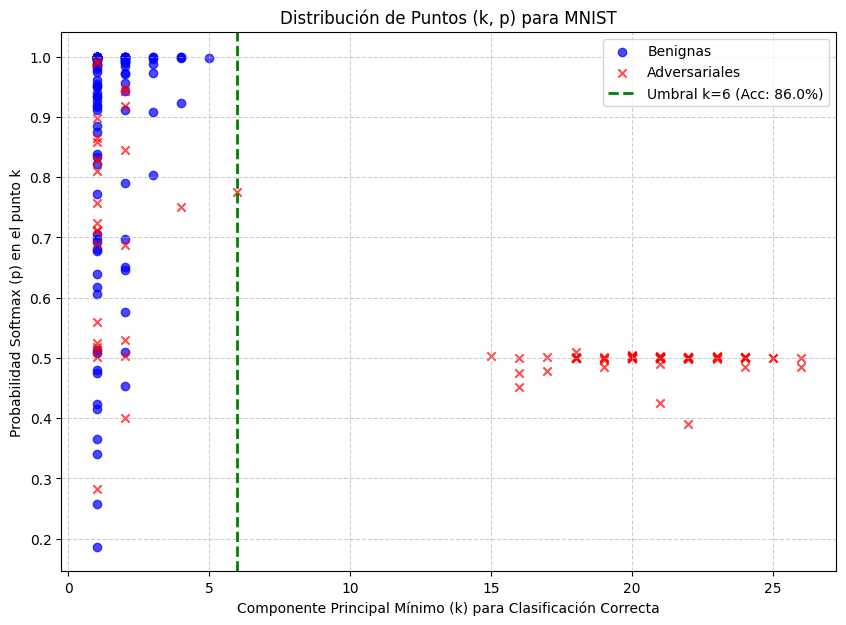

In [12]:
# --- Celda 6: Visualizar los Resultados y Detección con Umbral ---
if not benign_kp_points or not adv_kp_points:
    print("No se pudieron calcular suficientes puntos (k,p) para visualizar.")
else:
    benign_k, benign_p = zip(*benign_kp_points)
    adv_k, adv_p = zip(*adv_kp_points)

    plt.figure(figsize=(10, 7))
    plt.scatter(benign_k, benign_p, alpha=0.7, label='Benignas', c='blue')
    plt.scatter(adv_k, adv_p, alpha=0.7, label='Adversariales', c='red', marker='x')
    plt.title('Distribución de Puntos (k, p) para MNIST')
    plt.xlabel('Componente Principal Mínimo (k) para Clasificación Correcta')
    plt.ylabel('Probabilidad Softmax (p) en el punto k')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    # --- Detección Basada en Umbral con NumPy ---
    all_k = np.array(benign_k + adv_k)
    # 0 para benigno, 1 para adversarial
    true_labels = np.array([0] * len(benign_k) + [1] * len(adv_k))

    best_threshold = 0
    best_accuracy = 0

    # Probar todos los posibles umbrales para 'k'
    possible_thresholds = np.arange(1, int(np.max(all_k)) + 1)
    for threshold in possible_thresholds:
        # Regla: si k >= umbral, es adversarial (1)
        predicted_labels = (all_k >= threshold).astype(int)
        # Calcular precisión: (verdaderos positivos + verdaderos negativos) / total
        accuracy = np.mean(predicted_labels == true_labels)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_threshold = threshold

    print(f"\nMejor umbral para 'k' encontrado: {best_threshold}")
    print(f"Precisión de detección con este umbral: {best_accuracy * 100:.2f}%")

    # Dibujar la línea de umbral en el gráfico
    plt.axvline(x=best_threshold, color='green', linestyle='--', linewidth=2, label=f'Umbral k={best_threshold} (Acc: {best_accuracy*100:.1f}%)')
    plt.legend() # Actualizar leyenda
    plt.show()

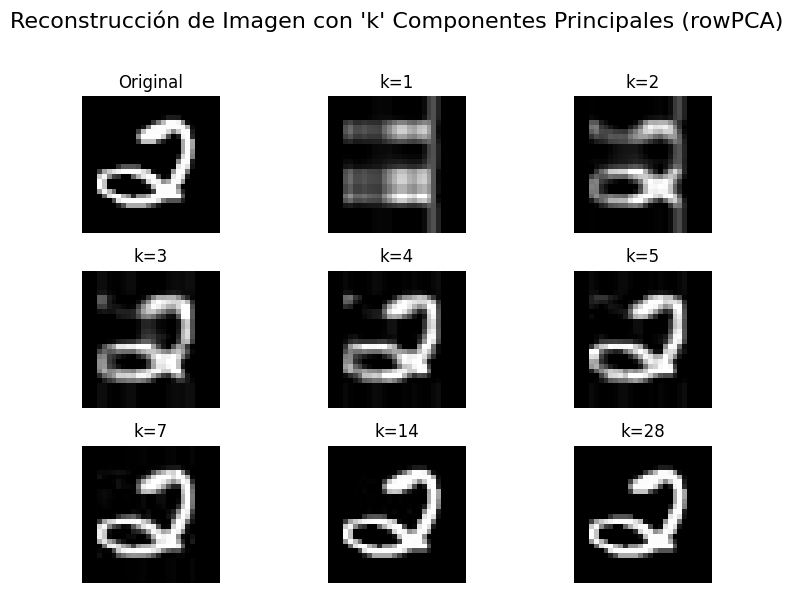

In [26]:
from pca.pca_detector import get_row_vectors, compute_principal_components, project_and_reconstruct


# 1. Usar la imagen de ejemplo que ya tenemos seleccionada
# (image_np, label, y original_pred_label ya están definidos de celdas anteriores)
if 'image_np' not in locals():
    print("Por favor, ejecuta las celdas anteriores para seleccionar una imagen de ejemplo ('image_np').")
else:
    # 2. Calcular los componentes principales de la imagen una sola vez
    row_vectors = get_row_vectors(image_np)
    mean_vector, principal_components = compute_principal_components(row_vectors)

    # 3. Definir los valores de 'k' que queremos visualizar
    k_values_to_show = [1, 2, 3, 4, 5, 7, 14, 28]

    # 4. Configurar la grilla de visualización
    fig, axes = plt.subplots(3, 3, figsize=(8, 6))
    plt.suptitle("Reconstrucción de Imagen con 'k' Componentes Principales (rowPCA)", fontsize=16)

    # Aplanar el array de ejes para facilitar la iteración
    ax = axes.ravel()

    # 5. Mostrar la imagen original en la primera posición
    # Recordar des-normalizar para la visualización
    mean_norm, std_norm = 0.1307, 0.3081
    original_vis = np.clip(image_np * std_norm + mean_norm, 0, 1)
    ax[0].imshow(original_vis.squeeze(), cmap='gray')
    ax[0].set_title("Original")
    ax[0].axis('off')

    # 6. Iterar y mostrar cada reconstrucción
    for i, k in enumerate(k_values_to_show):
        # El índice en el subplot será i + 1
        subplot_index = i + 1

        # Reconstruir la imagen con 'k' componentes
        reconstructed_vectors = project_and_reconstruct(row_vectors, k, mean_vector, principal_components)
        reconstructed_image_np = reconstructed_vectors.reshape(image_np.shape)

        # Des-normalizar para visualizar
        reconstructed_vis = np.clip(reconstructed_image_np * std_norm + mean_norm, 0, 1)

        # Mostrar en el subplot correspondiente
        ax[subplot_index].imshow(reconstructed_vis.squeeze(), cmap='gray')
        ax[subplot_index].set_title(f"k={k}")
        ax[subplot_index].axis('off')

    # Si hay subplots vacíos, los ocultamos
    for i in range(len(k_values_to_show) + 1, len(ax)):
        ax[i].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [28]:
# --- Celda 6: Guardar y Descargar los Resultados (CORREGIDA) ---

import shutil # Importamos la librería shutil

# Montar Google Drive si no está montado
from google.colab import drive
if not os.path.ismount('/content/drive'):
    drive.mount('/content/drive')

model_save_path = "mnist_cnn_trained.pth"

save_dir = '/content/drive/MyDrive/MNIST_Adversarial_Data/'
os.makedirs(save_dir, exist_ok=True)

if 'benign_images' in locals() and benign_images:
    # Mover el modelo guardado a Drive usando shutil.move
    if os.path.exists(model_save_path):
        shutil.move(model_save_path, os.path.join(save_dir, model_save_path))

    # Guardar los arrays de imágenes y distancias
    np.save(os.path.join(save_dir, "mnist_benign_images_xray.npy"), np.array(benign_images))
    np.save(os.path.join(save_dir, "mnist_adv_images_xray.npy"), np.array(adv_images))

    print("\nArchivos guardados en tu Google Drive en la carpeta 'MNIST_Adversarial_Data/':")
    print(f"- {model_save_path}")
    print("- mnist_benign_images_xray.npy")
    print("- mnist_adv_images_xray.npy")

    print("\n¡Ya puedes descargar esta carpeta desde Google Drive a tu PC local para el análisis!")
else:
    print("No se generaron imágenes adversariales, por lo que no se guardó nada.")


Archivos guardados en tu Google Drive en la carpeta 'MNIST_Adversarial_Data/':
- mnist_cnn_trained.pth
- mnist_benign_images_xray.npy
- mnist_adv_images_xray.npy

¡Ya puedes descargar esta carpeta desde Google Drive a tu PC local para el análisis!
